## Аналіз A/B тесту

Маємо проаналізувати дані A/B тесту в популярній [грі Cookie Cats](https://www.facebook.com/cookiecatsgame). Це класична гра-головоломка в стилі «з’єднай три», де гравець повинен з’єднати плитки одного кольору, щоб очистити дошку та виграти рівень. На дошці також зображені співаючі котики :)

Під час проходження гри гравці стикаються з воротами, які змушують їх чекати деякий час, перш ніж вони зможуть прогресувати або зробити покупку в додатку. У цьому блоці завдань ми проаналізуємо результати A/B тесту, коли перші ворота в Cookie Cats було переміщено з рівня 30 на рівень 40. Зокрема, ми проаналізуємо вплив на утримання (retention) гравців. Тобто хочемо зрозуміти чи переміщення воріт на 10 рівнів пізніше якимось чином вплинуло на те, що користувачі перестають грати в гру раніше чи пізніше з точки зору кількості їх днів з моменту встановлення гри.

Будемо працювати з даними з файлу `cookie_cats.csv`. Змінні в даних наступні:

- userid - унікальний номер, який ідентифікує кожного гравця.
- version - чи потрапив гравець в контрольну групу (gate_30 - ворота на 30 рівні) чи тестову групу (gate_40 - ворота на 40 рівні).
- sum_gamerounds - кількість ігрових раундів, зіграних гравцем протягом першого тижня після встановлення
- retention_1 - чи через 1 день після встановлення гравець повернувся і почав грати?
- retention_7 - чи через 7 днів після встановлення гравець повернувся і почав грати?

Коли гравець встановлював гру, його випадковим чином призначали до групи gate_30 або gate_40.

1. Зчитайте дані АВ тесту у змінну `df` та виведіть середнє значення показника показник `retention_7` (утримання на 7 день) по версіям гри. Сформулюйте гіпотезу: яка версія дає краще утримання через 7 днів після встановлення гри?

In [94]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib as mpl
import matplotlib.pyplot as plt
import statsmodels.stats.api as sms
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

%matplotlib inline

# Set default parameters for LaTex and font
plt.rcParams['font.family'] = 'serif'
plt.rcParams['text.usetex'] = True

ALPHA = 0.05
CRITICAL_CHI2_VALUE_1DOF_005ALPHA = 3.841

In [2]:
data_path = 'data_statistics/cookie_cats.csv'
df = pd.read_csv(data_path)
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [9]:
df.shape

(90189, 5)

In [8]:
retention_7_mean = df.groupby('version')['retention_7'].mean()
retention_7_mean

version
gate_30    0.190201
gate_40    0.182000
Name: retention_7, dtype: float64

<p style='font-family: Garamond ; font-size: 16px;'>Припустимо, що <code>gate_30</code> - версія, що дає краще утримання через 7 днів після встановлення гри.</p>
<p style='font-family: Garamond ; font-size: 18px;'><b>Формуємо наступні нульову та альтернативну гіпотези:</b></p>
<p style='font-family: Garamond ; font-size: 18px;'>$H_0$: немає різниці retention через 7 днів між версіями (пропорції однакові між <code>gate_30</code> та <code>gate_40</code>).</p>
<p style='font-family: Garamond ; font-size: 18px;'>$H_1$: є різниця в утриманні (пропорції різні між <code>gate_30</code> та <code>gate_40</code>). При чому, відповідно до середніх значень показників (математичного сподівання генеральної сукупності згідно з показником retention для кожної з груп або ж коректніше було б сформулювати те, що це є вибірковим середнім для кожної з категорій рівня воріт) - <code>gate_30</code> має вищий retention, аніж <code>gate_40</code>.</p>

2. Перевірте з допомогою z-тесту аналогічно до прикладу в лекції, чи дає якась з версій гри кращий показник `retention_7` на рівні значущості 0.05. Обчисліть також довірчі інтервали для двох вибірок. Виведіть результат у форматі:
```
z statistic: ...
p-value: ...
Довірчий інтервал 95% для групи control: [..., ...]
Довірчий інтервал 95% для групи treatment: [..., ...]
```
де замість `...` - обчислені значення. В якості висновка дайте відповідь на два питання:  
    1. чи є статистична значущою різниця між поведінкою користувачів у різних версіях гри?   
    2. чи перетинаються довірчі інтервали утримання користувачів з різних версій гри? Про що це каже?  
    
Зверніть увагу, в такому і схожому завданнях ми використовуєм `proportion` Z-тест. Це тому що в нас залежна змінна має бінарне значення (повернеться аби ні користувач, чи клікне або ні користувач в інших ситуаціях - всього два можливих значення в змінної: 0/1, True/False ). Якщо б ми вимірювали скажімо чи є стат. значущою різниця між вагою чоловіків і жінок в певній вибірці, ми б використовувавли функцію `statsmodels.stats.ztest`, бо залежна змінна `вага` є неперервною (тип float, замість типу int чи bool і тільки двох можливих значень).

<p style='font-family: Garamond ; font-size: 16px;'><b>!NOTA BENE</b> Ми маємо достатньо даних для прооведення тесту на повних семплах (за фільтрації початкового датасету), проте проведемо A|B тест за двох випадків:</p>
<ol style='font-family: Garamond ; font-size: 16px;'>
    <li>За розрахунку <code>proportion effect size</code> та його застосування, використовуючи формулу Cohen's h: $h = 2 \cdot \arcsin(\sqrt{p_1}) - 2 \cdot \arcsin(\sqrt{p_2})$.</li>
    <li>Без застосування <code>proportion effect size</code>, оскільки ми з самого початку маємо повну кулькість даних, проте, за будь-якого випадку, нам необхідно обчислити заданий параметр, аби переконатися в тому, що A|B тест є ефективним.</li>
</ol>

In [10]:
control_group = df[df['version'] == 'gate_30']['retention_7']
treatment_group = df[df['version'] == 'gate_40']['retention_7']

In [11]:
p_control = control_group.mean()
p_treatment = treatment_group.mean()

h = 2 * np.arcsin(np.sqrt(p_treatment)) - 2 * np.arcsin(np.sqrt(p_control))

print(f"Proportion effect size (Cohen's h): {h}")

Proportion effect size (Cohen's h): -0.021074001016365917


In [13]:
required_n = sms.NormalIndPower().solve_power(
    h,
    power=0.8,
    alpha=0.05,
    ratio=1
    )                                                  

required_n = ceil(required_n)                         

print(required_n)

35347


In [42]:
control_group.shape, treatment_group.shape

((44700,), (45489,))

In [80]:
session_counts = df['userid'].value_counts(ascending=False)
multi_users = session_counts[session_counts > 1].count()

print(f'There is {multi_users} duplicates in the input dataset.')

There is 0 duplicates in the input dataset.


In [43]:
control_sample = df[df['version'] == 'gate_30'].sample(n=required_n, random_state=22)
treatment_sample = df[df['version'] == 'gate_40'].sample(n=required_n, random_state=22)

ab_test = pd.concat([control_sample, treatment_sample], axis=0)
ab_test.reset_index(drop=True, inplace=True)

In [44]:
ab_test.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,7540471,gate_30,45,True,False
1,3589138,gate_30,21,True,False
2,3177668,gate_30,14,True,False
3,2133884,gate_30,26,False,False
4,492763,gate_30,39,True,True


In [81]:
control_results = ab_test[ab_test['version'] == 'gate_30']['retention_7']
treatment_results = ab_test[ab_test['version'] == 'gate_40']['retention_7']

n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'The confidence interval 95% for the control group: [{lower_con:.5f}, {upper_con:.5f}]')
print(f'The confidence interval 95% for the treatment group: [{lower_treat:.5f}, {upper_treat:.5f}]')


z statistic: 2.90
p-value: 0.004
The confidence interval 95% for the control group: [0.18530, 0.19346]
The confidence interval 95% for the treatment group: [0.17691, 0.18493]


In [83]:
if pval < ALPHA:
    print('The null hypothesis H₀ is rejected: There is a difference in retention (the proportions are different between gate_30 and gate_40). Moreover, according to the average values (the expected value of the population based on the retention metric for each group, or more correctly, it would be formulated as the sample mean for each of the gate level categories) - gate_30 has a higher retention than gate_40.')
else:
    print('The null hypothesis H₀ is not rejected: there is no effect on retention level in 7 days betweet gate_30 and gate_40 group.')

The null hypothesis H₀ is rejected: There is a difference in retention (the proportions are different between gate_30 and gate_40). Moreover, according to the average values (the expected value of the population based on the retention metric for each group, or more correctly, it would be formulated as the sample mean for each of the gate level categories) - gate_30 has a higher retention than gate_40.


In [88]:
retention_means = df.groupby('version')['retention_7'].mean()

successes = df.groupby('version')['retention_7'].sum().values
nobs = df.groupby('version')['retention_7'].count().values

z_stat, p_value = proportions_ztest(count=successes, nobs=nobs)

conf_int_control = proportion_confint(count=successes[0], nobs=nobs[0], alpha=0.05)
conf_int_treatment = proportion_confint(count=successes[1], nobs=nobs[1], alpha=0.05)

results = {
    'The mean value of retention_7 (control)': retention_means.loc['gate_30'],
    'The mean value of retention_7 (treatment)': retention_means.loc['gate_40'],
    'z statistic': z_stat,
    'p-value': p_value,
    'The confidence interval 95% for the control group:': conf_int_control,
    'The confidence interval 95% for the treatment group:': conf_int_treatment
}

results

{'The mean value of retention_7 (control)': np.float64(0.19020134228187918),
 'The mean value of retention_7 (treatment)': np.float64(0.18200004396667327),
 'z statistic': np.float64(3.164358912748191),
 'p-value': np.float64(0.001554249975614329),
 'The confidence interval 95% for the control group:': (0.18656311652199903,
  0.19383956804175934),
 'The confidence interval 95% for the treatment group:': (0.17845430073314686,
  0.18554578720019968)}

In [85]:
if p_value < ALPHA:
    print('The null hypothesis H₀ is rejected: There is a difference in retention (the proportions are different between gate_30 and gate_40). Moreover, according to the average values (the expected value of the population based on the retention metric for each group, or more correctly, it would be formulated as the sample mean for each of the gate level categories) - gate_30 has a higher retention than gate_40.')
else:
    print('The null hypothesis H₀ is not rejected: there is no effect on retention level in 7 days betweet gate_30 and gate_40 group.')

The null hypothesis H₀ is rejected: There is a difference in retention (the proportions are different between gate_30 and gate_40). Moreover, according to the average values (the expected value of the population based on the retention metric for each group, or more correctly, it would be formulated as the sample mean for each of the gate level categories) - gate_30 has a higher retention than gate_40.


<p style='font-family: Garamond ; font-size: 16px;'>Із розрахунку proportion effect size (Cohen's h) маємо -0.021074001016365917. Якщо <code>proportion effect size</code> є від'ємним, це означає, що пропорція утримання в тестовій групі менша, ніж у контрольній групі. Тобто результат тесту свідчить про те, що переміщення воріт з рівня 30 на рівень 40 мало негативний ефект на утримання гравців у тестовій групі.</p>
<p style='font-family: Garamond ; font-size: 16px;'>Наші confidence intervals для контрольно та тестової груп не перетинаються, що підтверджує, що різниця в показниках retention_7 є не лише статистично значущою, але й впевненою (результат стабільний).</p>
<p style='font-family: Garamond ; font-size: 16px;'>За результатом A|B тесту різниця між <code>retenton_7</code> для груп є статистично значущою, що ілюстративно додатково наведемо на графіку нижче (barplot).</p>

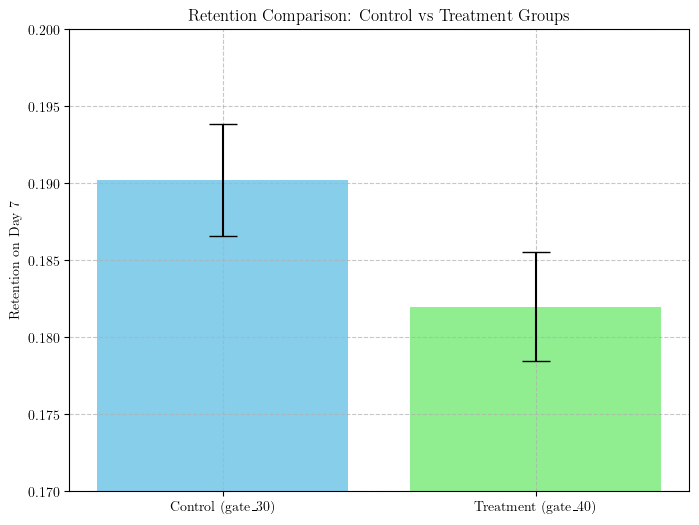

In [90]:
groups = ['Control (gate_30)', 'Treatment (gate_40)']
means = [results['The mean value of retention_7 (control)'], results['The mean value of retention_7 (treatment)']]
errors = [
    (results['The mean value of retention_7 (control)'] - results['The confidence interval 95% for the control group:'][0],
     results['The confidence interval 95% for the control group:'][1] - results['The mean value of retention_7 (control)']),
    (results['The mean value of retention_7 (treatment)'] - results['The confidence interval 95% for the treatment group:'][0],
     results['The confidence interval 95% for the treatment group:'][1] - results['The mean value of retention_7 (treatment)'])
]

plt.figure(figsize=(8,6))
plt.bar(groups, means, yerr=list(zip(*errors)), capsize=10, color=['skyblue', 'lightgreen'])
plt.ylabel('Retention on Day 7')
plt.title('Retention Comparison: Control vs Treatment Groups')
plt.ylim(0.17, 0.20)
plt.grid(linestyle='--', alpha=0.7)
plt.show();

3. Є ще один тип тестів, який використовується для бінарної метрики як от "зробить юзер дію, чи ні" - тест [**Хі-квадрат**](https://www.bmj.com/about-bmj/resources-readers/publications/statistics-square-one/8-chi-squared-tests) (ще одне [пояснення](https://www.scribbr.com/statistics/chi-square-tests/) тесту з прикладами). В нього інші гіпотези Н0 і Н1 на відміну від z- та t-тестів. А також цей тест можна використовувати, якщо в нас більше за 2 досліджувані групи, тобто в нас не А/В тест, а А/B/C/D, наприклад.  

В **z- та t-тестах** (які відрізняються тим, що ми в першому не знаємо дисперсію генеральної сукупності, але якщо в нас великий набір даних, то ці два тести дають дуже схожі результати) **ми перевіряємо, чи є різниця у середніх показниках по групам користувачів**.  

А в **тесті Хі-квадрат ми перевіряємо чи є звʼязок між групою користувача і тим, чи він зробить цікаву нам дію**. Це ніби дослідження одного і того самого, але дещо різними способами. Для перевірки, можна виконувати кілька тестів (особливо, якщо один дає якийсь непереконливий результат типу р-значення 0.07 - наче і fail to regect H0 на рівні стат значущості 5%, але цікаво, що скажуть інші тести), тож, зробимо і ми тест хі-квадрат та порівняємо його результат з z-тестом.

Про різницю між тестами можна почитати ще [тут](https://stats.stackexchange.com/a/178860) - це просто пояснення користувача стековерфлоу, але там розумні люди сидять.

Для проведення хі-квадрат тесту скористаємось функцією з `scipy.stats` `chi2_contingency` для обчислення статистики хі-квадрат і р-значення для перевірки конкретної гіпотези. У цю функцію вам треба передати таблицю 2х2: кількість випадків для кожної версії гри і значення `retention_7`.

**Задача**: виконайте тест хі-квадрат на рівні значущості 5% аби визначити, чи є залежність між версією гри та тим, чи зайде гравець на 7ий день після встановлення гри.
Тут гіпотези наступні
- Н0: значення retention_7 не залежить від версії гри
- Н1: є залежність між версією гри і значенням retention_7

Виведіть p-значення та зробіть висновок.


In [78]:
# Створимо таблицю з кількістю користувачів для кожної версії гри та значення retention_7 (0 або 1)
contingency_table = pd.crosstab(df['version'], df['retention_7'])
contingency_table

retention_7,False,True
version,,
gate_30,36198,8502
gate_40,37210,8279


In [97]:
chi2_stat, p_value_chi2, dof, expected_freq = stats.chi2_contingency(contingency_table)
print(f'The test statistic (calculated CHI2): {chi2_stat}.\nThe p-value of the test: {p_value_chi2}.')
print(f'The degrees of freedom (dof = observed.size - sum(observed.shape) + observed.ndim - 1): {dof}.\nThe expected frequencies, based on the marginal sums of the table: {expected_freq}.')

The test statistic (calculated CHI2): 9.959086799559167.
The p-value of the test: 0.0016005742679058301.
The degrees of freedom (dof = observed.size - sum(observed.shape) + observed.ndim - 1): 1.
The expected frequencies, based on the marginal sums of the table: [[36382.90257127  8317.09742873]
 [37025.09742873  8463.90257127]].


In [98]:
if p_value_chi2 < ALPHA:
    print('The null hypothesis H₀ is rejected: there is a dependency between the game version and the retention_7 value.')
else:
    print('The null hypothesis H₀ is not rejected: the retention_7 value does not depend on the game version.')

The null hypothesis H₀ is rejected: there is a dependency between the game version and the retention_7 value.


In [95]:
if chi2_stat < CRITICAL_CHI2_VALUE_1DOF_005ALPHA:
    print('The null hypothesis H₀ is not rejected: the retention_7 value does not depend on the game version')
else:
    print('The null hypothesis H₀ is rejected: there is a dependency between the game version and the retention_7 value.')

The null hypothesis H₀ is rejected: there is a dependency between the game version and the retention_7 value.
